In [1]:
%load_ext autoreload
%autoreload 2
from Methods import JobOffers,dataframeHelpers

In [2]:
import os
import nltk
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [3]:
autoreload JobOffers,dataframeHelpers

In [4]:
# Only run this if you want to redo the translations
# JobOffers.writeTranslatedJobs(-1, firstEntry=1000, writeEvery=1000)

In [5]:
translatedOffers = JobOffers.readJsonFile("Data/output_v1.1.1000.translate.json")

In [6]:
jobsDf = dataframeHelpers.buildJobsDF("Data/output_v1.1.1000.translate.json")

In [7]:
jobsDf

,JOB_ID,ISCO,JOB_CONTENT,ORIGINAL_CONTENT,TRANSLATED_JOBS,CANTON,COMPANY_SIZE
0,12220025,21420,[We are a successful and independent engineeri...,<p>Wir sind ein erfolgreiches und unabhängiges...,We are a successful and independent engineerin...,[BE],Kleinstunternehmen
1,10814567,21420,[We are a prestigious and successful engineeri...,Wir sind eine renommierte und erfolgreiche Ing...,We are a prestigious and successful engineerin...,[BE],Kleinstunternehmen
2,12401674,21420,[Bill Weyermann Partner AG has been producing ...,Bill Weyermann Partner AG erbringt seit über\n...,Bill Weyermann Partner AG has been producing e...,[BE],Kleinunternehmen
3,12473085,62100,[Administration Communale de Valderuzforstarti...,Administration communale de Val-de-RuzForstwar...,Administration Communale de Valderuzforstartin...,[NE],Kleinstunternehmen
4,12905109,26220;24210,[The Straumann Group is experiencing internati...,Le groupe Straumann connaît un succès internat...,The Straumann Group is experiencing internatio...,[BE],Mittelunternehmen
...,...,...,...,...,...,...,...
995,17126875,24210,[Vallorbe SA Metallurgical factories are recog...,<p>Les Usines Métallurgiques de Vallorbe SA (U...,Vallorbe SA Metallurgical factories are recogn...,[VD],Mittelunternehmen
996,17140922,43210;24210,[Back to Search Results Apply for this item OM...,<h2>Retour aux résultats de la recherche</h2>\...,Back to Search Results Apply for this item OME...,[BE],Grossunternehmen
997,17140923,24210,[Back to Search Results Apply for this item Om...,<h2>Retour aux résultats de la recherche</h2>\...,Back to Search Results Apply for this item Ome...,[BE],Grossunternehmen
998,17060287,24210,[You are here HomePlayController Quality HF Qu...,Vous êtes ici :AccueilEmploisContrôleur qualit...,You are here HomePlayController Quality HF Qua...,[BE],Kleinunternehmen


In [8]:
allJobsDf = dataframeHelpers.buildJobsDF("Data/output_v1.1.json", tokenize=True)
allJobsDf["NumSentences"] = allJobsDf.apply(lambda x: len(x["JOB_CONTENT"]), axis=1)
allJobsDf["NumCharacters"] = allJobsDf.apply(lambda x: sum([len(y) for y in x["JOB_CONTENT"]]), axis=1)
allJobsDf["CANTON1"] = allJobsDf.apply(lambda x: x["CANTON"][0], axis=1)

/Users/klong/Desktop/Thesis/env/lib/python3.8/site-packages/bs4/__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [9]:
allJobsDf["COMPANY_SIZE"] = allJobsDf["COMPANY_SIZE"].replace("Grossunternehmen", "Large")
allJobsDf["COMPANY_SIZE"] = allJobsDf["COMPANY_SIZE"].replace("Kleinstunternehmen", "Micro")
allJobsDf["COMPANY_SIZE"] = allJobsDf["COMPANY_SIZE"].replace("Kleinunternehmen", "Small")
allJobsDf["COMPANY_SIZE"] = allJobsDf["COMPANY_SIZE"].replace("Mittelunternehmen", "Midsize")

In [10]:
jobsDf

,JOB_ID,ISCO,JOB_CONTENT,ORIGINAL_CONTENT,TRANSLATED_JOBS,CANTON,COMPANY_SIZE
0,12220025,21420,[We are a successful and independent engineeri...,<p>Wir sind ein erfolgreiches und unabhängiges...,We are a successful and independent engineerin...,[BE],Kleinstunternehmen
1,10814567,21420,[We are a prestigious and successful engineeri...,Wir sind eine renommierte und erfolgreiche Ing...,We are a prestigious and successful engineerin...,[BE],Kleinstunternehmen
2,12401674,21420,[Bill Weyermann Partner AG has been producing ...,Bill Weyermann Partner AG erbringt seit über\n...,Bill Weyermann Partner AG has been producing e...,[BE],Kleinunternehmen
3,12473085,62100,[Administration Communale de Valderuzforstarti...,Administration communale de Val-de-RuzForstwar...,Administration Communale de Valderuzforstartin...,[NE],Kleinstunternehmen
4,12905109,26220;24210,[The Straumann Group is experiencing internati...,Le groupe Straumann connaît un succès internat...,The Straumann Group is experiencing internatio...,[BE],Mittelunternehmen
...,...,...,...,...,...,...,...
995,17126875,24210,[Vallorbe SA Metallurgical factories are recog...,<p>Les Usines Métallurgiques de Vallorbe SA (U...,Vallorbe SA Metallurgical factories are recogn...,[VD],Mittelunternehmen
996,17140922,43210;24210,[Back to Search Results Apply for this item OM...,<h2>Retour aux résultats de la recherche</h2>\...,Back to Search Results Apply for this item OME...,[BE],Grossunternehmen
997,17140923,24210,[Back to Search Results Apply for this item Om...,<h2>Retour aux résultats de la recherche</h2>\...,Back to Search Results Apply for this item Ome...,[BE],Grossunternehmen
998,17060287,24210,[You are here HomePlayController Quality HF Qu...,Vous êtes ici :AccueilEmploisContrôleur qualit...,You are here HomePlayController Quality HF Qua...,[BE],Kleinunternehmen


In [11]:
#Vika's file
VikaDf = pd.read_csv("Data/Environ_NonEnviron_Roberta_MJ.csv", sep=";")

In [12]:
#Emily's file
EmilyDf = pd.read_csv("Data/EmilyMJDifferentClassifications.csv", sep=";")

In [13]:
#All green's
GreenDf = pd.read_csv("Data/allGreenTranslated.csv", sep=";")

In [14]:
GreenDf = GreenDf.rename(columns ={"KANTONE":"CANTON"}) 
GreenDf = GreenDf.rename(columns ={"FIRMENGROESSE":"COMPANY_SIZE"}) 
GreenDf = GreenDf.rename(columns ={"ID":"JOB_ID"}) 

In [15]:
GreenDf

,Unnamed: 0,JOB_ID,ISCO,SKILLS,BRANCHE,ARBEITSORT,CANTON,COMPANY_SIZE,BERUFSERFAHRUNG,AUSBILDUNGSNIVEAU,ZUDATUM,ABDATUM,FIRMA,JOBTITEL,JOBS,CONTENT,CLEANED_JOBS,TRANSLATED_JOBS,MJ
0,0,20533641,20000,Kommunikationsfähigkeit;Umwelt;Python;Umsicht;...,Öffentliche Verwaltung,CH-1211 Genève,GE,Kleinstunternehmen,NaN,MASTER,43971,44001.0,Office fédéral de météorologie et de climatolo...,Collaboratrice/ Collaborateur scientifique 80%,Wissenschaftlicher Assistent,<p>L'Office fédéral de météorologie et de clim...,L'Office fédéral de météorologie et de climato...,The Federal Meteorology and Climatology Office...,NaN
1,1,20141197,21430,Kommunikationsfähigkeit;Nachhaltigkeit;Modelli...,Umwelttechnik;Rechts- und Unternehmensberatung,Lausanne,VD,Mittelunternehmen,NaN,BACHELOR;MASTER;BASICEDUCATION;MATURA;CERTIFIC...,43892,44031.0,Quantis International SA,Senior Sustainability Consultant,Umweltberater,<h1>Senior Sustainability Consultant</h1> <h2>...,Senior Sustainability Consultant Why youll lov...,Senior Sustainability Consultant Why youll lov...,NaN
2,2,20912180,21430,Hydraulik;Eigenverantwortung;Verantwortungsbew...,Personalberatung,1920 Martigny,VS,Grossunternehmen,NaN,BACHELOR;MASTER;DIPLOMA;UAS;UNIVERSITY,44047,44054.0,Adecco,Ingénieur en environnement EPF ou HES orientat...,Umweltschutztechniker,À la recherche d'une nouvelle opportunité en t...,À la recherche d'une nouvelle opportunité en t...,In search of a new opportunity as an environne...,NaN
3,3,19968711,21310;21410,Umwelt;Ingenieurwesen;Mitarbeitermotivation;Un...,Rechts- und Unternehmensberatung,CH-1203 Genève,GE,Kleinunternehmen,Ingenieur-Jobs;Techniker-Jobs;Postdienste von ...,BACHELOR;MASTER;COLLEGE;DIPLOMA,43864,44004.0,Ecotec Environnement SA,Un·e Spécialiste en renaturation de cours d'ea...,Biologe;Wirtschaftsingenieur,<h1>Offre d'emploi Un·e Spécialiste en renatur...,Offre d'emploi Une Spécialiste en renaturation...,Job Posting A Specialist in Renaturation of Co...,NaN
4,4,20506366,23000,F#;Garten- und Landschaftsbau,Bildung,CH 1422 Grandson,VD,Kleinunternehmen,NaN,NaN,43965,43990.0,LE REPUIS,Un maître socioprofessionnel (H/F) à 100% sect...,Lehrer,<p><strong>Un maître socioprofessionnel (H/F) ...,Un maître socioprofessionnel HF à 100 secteur ...,A Socioprofessional Master HF to 100 Sector Ho...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,120,20933760,24310;24210,Kommunikationsfähigkeit;Planung;Datacap;Proble...,Bildung,Genève,GE,Mittelunternehmen,Unterrichtsassistent;Lagerist;Logistik-Jobs,BACHELOR;MASTER;BASICEDUCATION;MATURA;CERTIFIC...,44051,NaN,ESDA l’Ecole Supérieure de Droit et d’Administ...,Looking for a Market Data Analyst / Program Ma...,Programmverantwortlicher;Business Intelligence...,<p>Emploi</p> <p>ESDA is looking for a Market ...,Emploi ESDA is looking for a Market Data Analy...,Emploi ESDA is looking for a Market Data Analy...,NaN
121,121,21930428,26220;41200,Git;Texten und Überarbeiten;Problemstrukturier...,NPO,CH-1211 Genève,GE,Mittelunternehmen,Informatiker-Jobs;Projektmanagement-Jobs;Daten...,BACHELOR;MASTER;COLLEGE;DIPLOMA;UNIVERSITY,44251,44296.0,UNOG United Nations Office at Geneva,ASSISTANT DATA ANALYST,Data Scientist;Administrativer Assistent,Org. Setting and Reporting <p> This position i...,Org. Setting and Reporting This position is l...,Org. Setting and Reporting This position is l...,NaN
122,122,22071257,26220,Kommunikationsfähigkeit;Mobilität;Kommunikatio...,Grosshandel;Maschinenbau;Fahrzeugbau;Baugewerbe,CH-1208 Genève,GE,Grossunternehmen,NaN,BACHELOR;MASTER;BASICEDUCATION;MATURA;CERTIFIC...,44277,44298.0,Caterpillar Sarl,Caterpillar Graduate Program - Junior Business...,Absolvent;Data Scientist,<h1>Caterpillar Graduate Program - Junior Busi...,Caterpillar Graduate Program Junior Business ...,Caterpillar Graduate Program Junior Business ...,NaN
123,123,18359929,21490,Effektivität;Einrichtungen;Modellieren;Begeist...,Architektur und Planung,CH-1228 Plan-les-Ouates,GE,Kleinstunternehmen,Verlags-Jo

In [16]:
VikaDfLabeled = VikaDf[~VikaDf["MJ"].isna()]

In [17]:
VikaDfLabeled = VikaDfLabeled.rename(columns ={"ID":"JOB_ID"}) 


In [18]:
GreenDf = GreenDf.rename(columns ={"ID":"JOB_ID"}) 


In [19]:
GreenDf = GreenDf[["JOB_ID", "MJ", "ISCO", "TRANSLATED_JOBS", "CANTON", "COMPANY_SIZE" ]]

In [20]:
GreenDf["MJ"] = 1

In [21]:
GreenDf["JOB_CONTENT"] = GreenDf.apply(lambda x: x["TRANSLATED_JOBS"].split("."), axis = 1)

In [22]:
GreenDf.loc[0]["JOB_CONTENT"]

['The Federal Meteorology and Climatology Office Meteosuisse is looking for on October 1,2020 or to agree with a collaborator scientifier 80 Geneva WeeGewsuisse good to know as collaboratorComponent scientist in the postprocessing team and verification you are responsible for the development and the Software operation for automatic processing of the large amount of information from time digital prediction templates',
 ' The postprocessing and audit team is part of the Meteosuisse Forecast Development Division is responsible for exploiting new methods of automatic forecasts as well as decision support systems',
 ' Your tasks develop and implement methods or programs for the production of weather forecasts, for example by aggregating different sources of information for feeding the Web sitesuisse and its mobile application',
 ' Apply Statistical Methods of Machine Learning to improve weather forecasts but also to develop tools for analyzing and visualizing meteorological data for interna

In [23]:
pd.merge(VikaDfLabeled, jobsDf, on = "JOB_ID")

,JOB_ID,ISCO_x,SKILLS,BRANCHE,JOBTITEL,CONTENT,Content English,Predictions,MJ,Unnamed: 9,Unnamed: 10,ISCO_y,JOB_CONTENT,ORIGINAL_CONTENT,TRANSLATED_JOBS,CANTON,COMPANY_SIZE
0,12047533,31230;12190;21620,Kontaktfähigkeit;Anpassungsfähigkeit;Einsatzbe...,Land- und Forstwirtschaft;Baugewerbe,Landschaftsgärtner / -in als Vorarbeiter / Gru...,Bauführer / Gartenbautechniker HF Die Aemmer ...,bauführer horticultural technician hf\nthe aem...,Environ,1,NaN,NaN,31230;12190;21620,[Building leaders Horticultural technician HF ...,Bauführer / Gartenbautechniker HF\n\nDie Aemme...,Building leaders Horticultural technician HF T...,[BE],Kleinstunternehmen
1,14422389,21620,Sozialrecht;Software-Entwicklungsprozess;Belas...,Bildung;Sozialwesen,Landschaftsgärtner/in (100%),Als Bildungs- und sozialpädagogisches Zentrum ...,as an educational and socio-pedagogical centre...,Environ,1,NaN,NaN,21620,[As an educational and social education center...,Als Bildungs- und sozialpädagogisches Zentrum ...,"As an educational and social education center,...",[BE],Kleinunternehmen
2,14616465,21420,Multitasking;Bauingenieurwesen;Microsoft Offic...,Architektur und Planung,Ingénieur en génie civil,Ingénieur en génie civil 1804 Corsier-sur-Ve...,civil engineering engineer\n\n\n1804 corsier-s...,Environ,1,NaN,NaN,21420,[Civil Engineer 1804 Corsiersurvey Engineering...,Ingénieur en génie civil\n\n\n1804 Corsier-sur...,Civil Engineer 1804 Corsiersurvey Engineering ...,[VD],Kleinstunternehmen
3,14617343,21620,Freizeitindustrie;Landschaftsarchitektur;Gesch...,NPO;Öffentliche Verwaltung,Praktikum Landschaftsentwicklung Naturpark Gan...,24.05.2017 Praktikum Landschaftsentwicklung N...,24.05.2017\n\npractical landscape development ...,Environ,1,NaN,NaN,21620,"[24, 05, 2017 Internship Landscape Developme...",24.05.2017\n\nPraktikum Landschaftsentwicklung...,24. 05. 2017 Internship Landscape Development ...,[BE],Kleinstunternehmen
4,14515774,21430,Verhandlungsgeschick;Stellenbeschreibung;Diens...,Öffentliche Verwaltung,Fachspezialist/in Biodiversität 70 - 100%,Firmenportrait Das Amt für Wald des Kantons ...,company portrait \n\nthe amt für wald des cant...,Environ,1,NaN,NaN,21430,[Company portrait The office for the forest of...,Firmenportrait \n\nDas Amt für Wald des Kanton...,Company portrait The office for the forest of ...,[BE],Mittelunternehmen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,7025892,21420,NaN,Architektur und Planung,dipl. Bauingenieur/in ETH / FH,* dipl. Bauingenieur/in ETH / FH * dipl. CAD-K...,Dipl. civil engineering in eth fh\n Dipl. c...,Non-Environ,pas de texte,NaN,NaN,21420,"[Dipl, Breafinery Eth fh Dipl, Cadostructors]",* dipl. Bauingenieur/in ETH / FH\n* dipl. CAD-...,Dipl.Breafinery Eth fh Dipl.Cadostructors,[VS],Kleinunternehmen
383,18910435,24210,Volksgesundheit;Verantwortungsbewusstsein;Sich...,Baugewerbe;Architektur und Planung,"Responsable qualité, et répondant général sant..."," Responsable qualité, et répondant général sa...",responsible for quality and general health and...,Environ,pas de texte,NaN,NaN,24210,[Quality Manager and Respondent General Health...,"<i></i>\n<h4>Responsable qualité, et répondan...",Quality Manager and Respondent General Health ...,[VD],Kleinstunternehmen
384,14008295,44190;24210,Qualitätsmanagement;Französisch,Lebensmittel,SPEZIALIST/IN QUALITÄTSSICHERUNG,FRDEEN * Home * Le groupe * Nos entreprises ...,frdeen\n\n home\n the group\n\n our compani...,Non-Environ,pas de texte,NaN,NaN,44190;24210,[FRDEEN HOME COMPANIES ESTAVAYER MILITY SA ELS...,FRDEEN\n\n* Home\n* Le groupe\n\n* Nos entrepr...,FRDEEN HOME COMPANIES ESTAVAYER MILITY SA ELSA...,[FR],Mittelunternehmen
385,16921607,24210,Qualifizierung;Qualitätsmanagement;Computer Sy...,Pharma und Chemie,QA Manager Qualification/Validation/EM (Enviro...,Lonza is one of the world’s leading and most-t...,lonza is one of the world’s leading and most-...,Environ,pas de texte,NaN,NaN,24210,[Lonza is one of the worlds leading and mosttr...,<p>Lo

In [24]:
len(VikaDfLabeled)

387

In [25]:
VikaDfLabeled = VikaDfLabeled[["JOB_ID", "MJ"]]


In [26]:
VikaDfLabeled

,JOB_ID,MJ
0,12047533,1
1,14422389,1
2,14616465,1
3,14617343,1
4,14515774,1
...,...,...
382,7025892,pas de texte
383,18910435,pas de texte
384,14008295,pas de texte
385,16921607,pas de texte


In [27]:
EmilyDf = EmilyDf[["JOB_ID", "MJ"]]


In [28]:
EmilyDf

,JOB_ID,MJ
0,13763695,False
1,12220025,False
2,14624002,False
3,12723029,False
4,14536882,True
5,11969310,True
6,13762077,True
7,13922235,False
8,13946158,False
9,13989853,True


In [29]:
#EmilyVikaDf = pd.merge(VikaDfLabeled, EmilyDf, on = "JOB_ID")

In [30]:
EmilyVikaDf = VikaDfLabeled.append(EmilyDf)

In [31]:
EmilyVikaDf

,JOB_ID,MJ
0,12047533,1
1,14422389,1
2,14616465,1
3,14617343,1
4,14515774,1
...,...,...
25,13762804,False
26,14239400,True
27,13823543,True
28,12723027,False


In [32]:
for label in ["pas de texte", "?", "False", False, "false", "FALSE", "non", "no", "no job offer text"]:
    EmilyVikaDf["MJ"] = EmilyVikaDf["MJ"].replace(label, 0)
for label in ["true", "True", True, "TRUE", "1"]:
    EmilyVikaDf["MJ"] = EmilyVikaDf["MJ"].replace(label, 1)

In [33]:
EmilyVikaDf = EmilyVikaDf[EmilyVikaDf["MJ"] != "same as above"]

In [34]:
EmilyVikaDf["MJ"].value_counts()

0    237
1    179
Name: MJ, dtype: int64

In [35]:
emilyVikaJobsMergedDf = EmilyVikaDf[["JOB_ID", "MJ"]].merge(jobsDf, on="JOB_ID", how="outer")

In [36]:
emilyVikaJobsMergedDf

,JOB_ID,MJ,ISCO,JOB_CONTENT,ORIGINAL_CONTENT,TRANSLATED_JOBS,CANTON,COMPANY_SIZE
0,12047533.0,1,31230;12190;21620,[Building leaders Horticultural technician HF ...,Bauführer / Gartenbautechniker HF\n\nDie Aemme...,Building leaders Horticultural technician HF T...,[BE],Kleinstunternehmen
1,14422389.0,1,21620,[As an educational and social education center...,Als Bildungs- und sozialpädagogisches Zentrum ...,"As an educational and social education center,...",[BE],Kleinunternehmen
2,14616465.0,1,21420,[Civil Engineer 1804 Corsiersurvey Engineering...,Ingénieur en génie civil\n\n\n1804 Corsier-sur...,Civil Engineer 1804 Corsiersurvey Engineering ...,[VD],Kleinstunternehmen
3,14617343.0,1,21620,"[24, 05, 2017 Internship Landscape Developme...",24.05.2017\n\nPraktikum Landschaftsentwicklung...,24. 05. 2017 Internship Landscape Development ...,[BE],Kleinstunternehmen
4,14515774.0,1,21430,[Company portrait The office for the forest of...,Firmenportrait \n\nDas Amt für Wald des Kanton...,Company portrait The office for the forest of ...,[BE],Mittelunternehmen
...,...,...,...,...,...,...,...,...
995,16995903.0,NaN,24210,[The Department of Social Affairs of Biel is l...,<b>Die Abteilung Soziales</b> der Stadt Biel s...,The Department of Social Affairs of Biel is lo...,[BE],Kleinunternehmen
996,17136796.0,NaN,43210;24210,[Back to Search Results Apply for this item OM...,<h2>Retour aux résultats de la recherche</h2>\...,Back to Search Results Apply for this item OME...,[BE],Kleinunternehmen
997,17140922.0,NaN,43210;24210,[Back to Search Results Apply for this item OM...,<h2>Retour aux résultats de la recherche</h2>\...,Back to Search Results Apply for this item OME...,[BE],Grossunternehmen
998,17140923.0,NaN,24210,[Back to Search Results Apply for this item Om...,<h2>Retour aux résultats de la recherche</h2>\...,Back to Search Results Apply for this item Ome...,[BE],Grossunternehmen


In [37]:
mergedDf = emilyVikaJobsMergedDf[emilyVikaJobsMergedDf.columns.intersection(GreenDf.columns)].append(GreenDf)

In [38]:
mergedDf = mergedDf.reset_index()

In [39]:
mergedDf["NumSentences"] = mergedDf.apply(lambda x: len(x["JOB_CONTENT"]), axis=1)
mergedDf["NumCharacters"] = mergedDf.apply(lambda x: sum([len(y) for y in x["JOB_CONTENT"]]), axis=1)

In [40]:
mergedDf["MJ"].value_counts()

1    304
0    237
Name: MJ, dtype: int64

In [41]:
mergedDf["CANTON"] = mergedDf.apply(lambda x: x["CANTON"].split(";") if type(x["CANTON"]) == str else x["CANTON"], axis=1)

In [42]:
mergedDf["COMPANY_SIZE"] = mergedDf["COMPANY_SIZE"].replace("Grossunternehmen", "Large")
mergedDf["COMPANY_SIZE"] = mergedDf["COMPANY_SIZE"].replace("Kleinstunternehmen", "Micro")
mergedDf["COMPANY_SIZE"] = mergedDf["COMPANY_SIZE"].replace("Kleinunternehmen", "Small")
mergedDf["COMPANY_SIZE"] = mergedDf["COMPANY_SIZE"].replace("Mittelunternehmen", "Midsize")

In [43]:
mergedDf["CANTON1"] = mergedDf.apply(lambda x: x["CANTON"][0] if type(x["CANTON"]) != str else x["CANTON"], axis=1)

In [44]:
labeledDf = mergedDf[~mergedDf["MJ"].isna()]

In [45]:
labeledDf["MJ"] = labeledDf["MJ"].astype('bool')

<ipython-input-45-c9fa01c0230e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeledDf["MJ"] = labeledDf["MJ"].astype('bool')


In [46]:
labeledDf["MJ"].value_counts()

True     304
False    237
Name: MJ, dtype: int64

In [47]:
mergedDf.loc[525]

index                     525
JOB_ID             18236493.0
MJ                        NaN
ISCO                    21640
JOB_CONTENT                []
TRANSLATED_JOBS              
CANTON                   [BE]
COMPANY_SIZE          Midsize
NumSentences                1
NumCharacters               0
CANTON1                    BE
Name: 525, dtype: object

In [48]:
mergedDf[mergedDf["TRANSLATED_JOBS"] != ""]

,index,JOB_ID,MJ,ISCO,JOB_CONTENT,TRANSLATED_JOBS,CANTON,COMPANY_SIZE,NumSentences,NumCharacters,CANTON1
0,0,12047533.0,1,31230;12190;21620,[Building leaders Horticultural technician HF ...,Building leaders Horticultural technician HF T...,[BE],Micro,25,1827,BE
1,1,14422389.0,1,21620,[As an educational and social education center...,"As an educational and social education center,...",[BE],Small,15,2278,BE
2,2,14616465.0,1,21420,[Civil Engineer 1804 Corsiersurvey Engineering...,Civil Engineer 1804 Corsiersurvey Engineering ...,[VD],Micro,12,1347,VD
3,3,14617343.0,1,21620,"[24, 05, 2017 Internship Landscape Developme...",24. 05. 2017 Internship Landscape Development ...,[BE],Micro,7,500,BE
4,4,14515774.0,1,21430,[Company portrait The office for the forest of...,Company portrait The office for the forest of ...,[BE],Midsize,21,1848,BE
...,...,...,...,...,...,...,...,...,...,...,...
1120,120,20933760.0,1,24310;24210,[Emploi ESDA is looking for a Market Data Anal...,Emploi ESDA is looking for a Market Data Analy...,[GE],Midsize,12,3486,GE
1121,121,21930428.0,1,26220;41200,"[Org, Setting and Reporting This position is...",Org. Setting and Reporting This position is l...,[GE],Midsize,66,9579,GE
1122,122,22071257.0,1,26220,[Caterpillar Graduate Program Junior Business...,Caterpillar Graduate Program Junior Business ...,[GE],Large,21,4254,GE
1123,123,18359929.0,1,21490,"[Energy Energy Management Raymond E, Moser ha...",Energy Energy Management Raymond E. Moser has ...,[GE],Micro,24,2311,GE


In [49]:
mergedDf[mergedDf["TRANSLATED_JOBS"] != ""].to_csv("Data/mergedJobs1000.csv")

In [50]:
labeledDf.to_csv("Data/mergedAnnotatedJobsDf.csv")

9 8 7


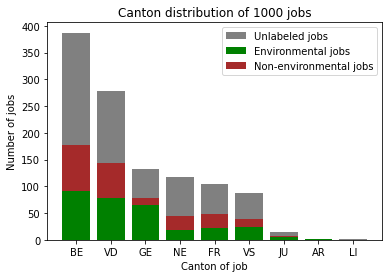

In [51]:
allvalues = mergedDf["CANTON1"].value_counts()
valuesGreen = mergedDf[mergedDf["MJ"] == True]["CANTON1"].value_counts()
valuesNotGreen = mergedDf[mergedDf["MJ"] == False]["CANTON1"].value_counts()
print(len(allvalues), len(valuesGreen), len(valuesNotGreen))
plt.bar(allvalues.index, allvalues, color='grey', label="Unlabeled jobs")
plt.bar(valuesGreen.index, valuesGreen, color='green', label="Environmental jobs")
plt.bar(valuesNotGreen.index, valuesNotGreen, bottom=valuesGreen[valuesNotGreen.index], color="brown", label="Non-environmental jobs")
plt.xlabel("Canton of job")
plt.ylabel("Number of jobs")
plt.title("Canton distribution of 1000 jobs")
plt.legend()
plt.savefig("Plots/CantonDist.pdf")

In [52]:
valuesGreen

BE    91
VD    78
GE    65
VS    23
FR    22
NE    18
JU     5
AR     2
Name: CANTON1, dtype: int64

In [53]:
labeledDf

,index,JOB_ID,MJ,ISCO,JOB_CONTENT,TRANSLATED_JOBS,CANTON,COMPANY_SIZE,NumSentences,NumCharacters,CANTON1
0,0,12047533.0,True,31230;12190;21620,[Building leaders Horticultural technician HF ...,Building leaders Horticultural technician HF T...,[BE],Micro,25,1827,BE
1,1,14422389.0,True,21620,[As an educational and social education center...,"As an educational and social education center,...",[BE],Small,15,2278,BE
2,2,14616465.0,True,21420,[Civil Engineer 1804 Corsiersurvey Engineering...,Civil Engineer 1804 Corsiersurvey Engineering ...,[VD],Micro,12,1347,VD
3,3,14617343.0,True,21620,"[24, 05, 2017 Internship Landscape Developme...",24. 05. 2017 Internship Landscape Development ...,[BE],Micro,7,500,BE
4,4,14515774.0,True,21430,[Company portrait The office for the forest of...,Company portrait The office for the forest of ...,[BE],Midsize,21,1848,BE
...,...,...,...,...,...,...,...,...,...,...,...
1120,120,20933760.0,True,24310;24210,[Emploi ESDA is looking for a Market Data Anal...,Emploi ESDA is looking for a Market Data Analy...,[GE],Midsize,12,3486,GE
1121,121,21930428.0,True,26220;41200,"[Org, Setting and Reporting This position is...",Org. Setting and Reporting This position is l...,[GE],Midsize,66,9579,GE
1122,122,22071257.0,True,26220,[Caterpillar Graduate Program Junior Business...,Caterpillar Graduate Program Junior Business ...,[GE],Large,21,4254,GE
1123,123,18359929.0,True,21490,"[Energy Energy Management Raymond E, Moser ha...",Energy Energy Management Raymond E. Moser has ...,[GE],Micro,24,2311,GE


4 4 4


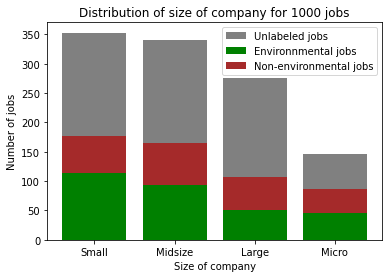

In [54]:
values = mergedDf["COMPANY_SIZE"].value_counts()
valuesGreen = mergedDf[mergedDf["MJ"] == True]["COMPANY_SIZE"].value_counts()
valuesNotGreen = mergedDf[mergedDf["MJ"] == False]["COMPANY_SIZE"].value_counts()
print(len(values), len(valuesGreen), len(valuesNotGreen))
plt.bar(values.index, values, color='grey', label="Unlabeled jobs")
plt.bar(valuesGreen.index, valuesGreen, color='green', label="Environnmental jobs")
plt.bar(valuesNotGreen.index, valuesNotGreen, bottom=valuesGreen[valuesNotGreen.index], color="brown", label="Non-environmental jobs")
plt.xlabel("Size of company")
plt.ylabel("Number of jobs")
plt.title("Distribution of size of company for 1000 jobs")
plt.savefig("Plots/CompanySize.pdf")
plt.legend()

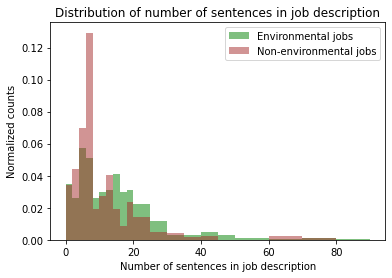

In [55]:
bins = list(range(0, 20, 2))+list(range(20, 50, 5))+list(range(50,100,10))
#plt.hist(mergedDf["NumSentences"], bins=bins, density=True, color="grey")
plt.hist(mergedDf[mergedDf["MJ"] == True]["NumSentences"], bins=bins, density=True, color="green", alpha=0.5, label="Environmental jobs")
plt.hist(mergedDf[mergedDf["MJ"] == False]["NumSentences"], bins=bins, density=True, color="brown", alpha=0.5, label="Non-environmental jobs")
plt.xlabel("Number of sentences in job description")
plt.ylabel("Normalized counts")
plt.legend()
plt.title("Distribution of number of sentences in job description")
plt.savefig("Plots/SentenceLength.pdf")


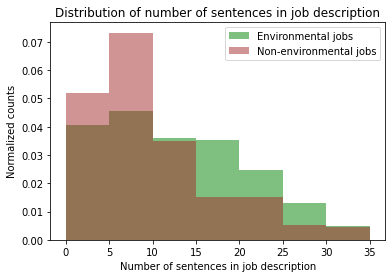

In [56]:
bins = list(range(0, 40, 5))
#plt.hist(mergedDf["NumSentences"], bins=bins, density=True, color="grey")
plt.hist(mergedDf[mergedDf["MJ"] == True]["NumSentences"], bins=bins, density=True, color="green", alpha=0.5, label="Environmental jobs")
plt.hist(mergedDf[mergedDf["MJ"] == False]["NumSentences"], bins=bins, density=True, color="brown", alpha=0.5, label="Non-environmental jobs")
plt.xlabel("Number of sentences in job description")
plt.ylabel("Normalized counts")
plt.legend()
plt.title("Distribution of number of sentences in job description")
plt.savefig("Plots/SentenceLengthZoomed.pdf")


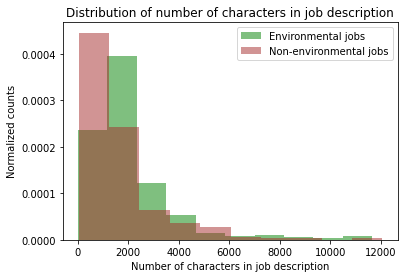

In [57]:
#bins = list(range(0, 20, 2))+list(range(20, 50, 5))+list(range(50,100,10))
#plt.hist(mergedDf["NumSentences"], bins=bins, density=True, color="grey")
plt.hist(mergedDf[mergedDf["MJ"] == True]["NumCharacters"],  density=True, color="green", alpha=0.5, label="Environmental jobs")
plt.hist(mergedDf[mergedDf["MJ"] == False]["NumCharacters"], density=True, color="brown", alpha=0.5, label="Non-environmental jobs")
plt.xlabel("Number of characters in job description")
plt.ylabel("Normalized counts")
plt.legend()
plt.title("Distribution of number of characters in job description")
plt.savefig("Plots/CharLength.pdf")


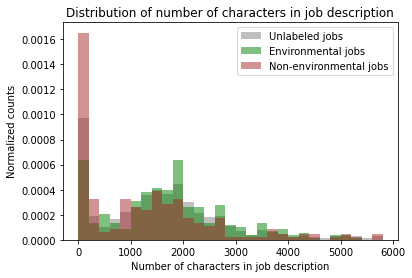

In [58]:
bins = list(range(0, 6000, 200))
plt.hist(mergedDf["NumCharacters"], bins=bins, density=True, color="grey", alpha = 0.5, label = "Unlabeled jobs")
plt.hist(mergedDf[mergedDf["MJ"] == True]["NumCharacters"], bins=bins, density=True, color="green", alpha=0.5, label="Environmental jobs")
plt.hist(mergedDf[mergedDf["MJ"] == False]["NumCharacters"], bins =bins, density=True, color="brown", alpha=0.5, label="Non-environmental jobs")
plt.xlabel("Number of characters in job description")
plt.ylabel("Normalized counts")
plt.legend()
plt.title("Distribution of number of characters in job description")
plt.savefig("Plots/CharLengthZoomed.pdf")


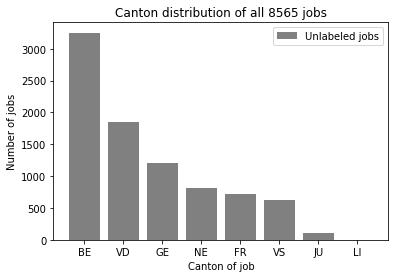

In [59]:
allvalues = allJobsDf["CANTON1"].value_counts()
plt.bar(allvalues.index, allvalues, color='grey', label="Unlabeled jobs")
plt.xlabel("Canton of job")
plt.ylabel("Number of jobs")
plt.title("Canton distribution of all 8565 jobs")
plt.legend()
plt.savefig("Plots/CantonDistAll.pdf")


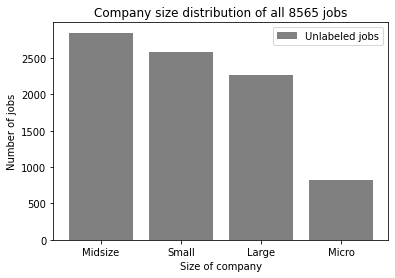

In [60]:
allvalues = allJobsDf["COMPANY_SIZE"].value_counts()
plt.bar(allvalues.index, allvalues, color='grey', label="Unlabeled jobs")
plt.xlabel("Size of company")
plt.ylabel("Number of jobs")
plt.title("Company size distribution of all 8565 jobs")
plt.legend()
plt.savefig("Plots/CompanySizeAll.pdf")

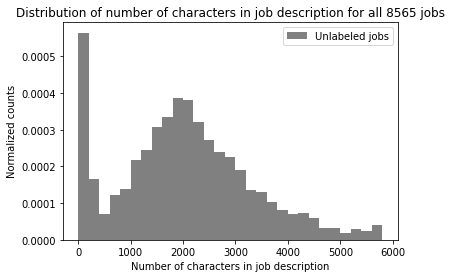

In [61]:
bins = list(range(0, 6000, 200))
#plt.hist(mergedDf["NumSentences"], bins=bins, density=True, color="grey")
plt.hist(allJobsDf["NumCharacters"], bins=bins, density=True, color="grey", label="Unlabeled jobs")
plt.xlabel("Number of characters in job description")
plt.ylabel("Normalized counts")
plt.legend()
plt.title("Distribution of number of characters in job description for all 8565 jobs")
plt.savefig("Plots/CharLengthAll.pdf")


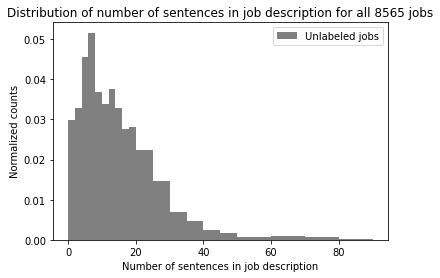

In [62]:
bins = list(range(0, 20, 2))+list(range(20, 50, 5))+list(range(50,100,10))
#plt.hist(mergedDf["NumSentences"], bins=bins, density=True, color="grey")
plt.hist(allJobsDf["NumSentences"], bins=bins, density=True, color="grey", label="Unlabeled jobs")
plt.xlabel("Number of sentences in job description")
plt.ylabel("Normalized counts")
plt.legend()
plt.title("Distribution of number of sentences in job description for all 8565 jobs")
plt.savefig("Plots/SentenceLengthAll.pdf")